In [1]:
import os,sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import math

In [2]:
%matplotlib inline

In [3]:
matplotlib.get_configdir()

u'/home/prateeks/.config/matplotlib'

In [4]:
#plt.style.use('plt-paper-style')

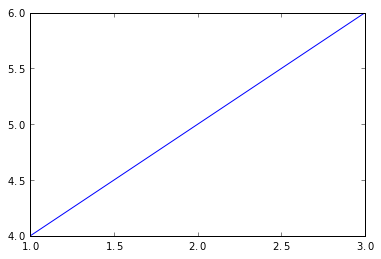

In [5]:
plt.plot([1,2,3],[4,5,6])

In [ ]:
plt.show()

Exception in Tkinter callback
Traceback (most recent call last):
  File "/usr/lib/python2.7/lib-tk/Tkinter.py", line 1544, in __call__
    return self.func(*args)
  File "/usr/local/lib/python2.7/dist-packages/matplotlib/backends/backend_tkagg.py", line 283, in resize
    self.show()
  File "/usr/local/lib/python2.7/dist-packages/matplotlib/backends/backend_tkagg.py", line 354, in draw
    FigureCanvasAgg.draw(self)
  File "/usr/local/lib/python2.7/dist-packages/matplotlib/backends/backend_agg.py", line 474, in draw
    self.figure.draw(self.renderer)
  File "/usr/local/lib/python2.7/dist-packages/matplotlib/artist.py", line 62, in draw_wrapper
    draw(artist, renderer, *args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py", line 1159, in draw
    func(*args)
  File "/usr/local/lib/python2.7/dist-packages/matplotlib/artist.py", line 62, in draw_wrapper
    draw(artist, renderer, *args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/matplotlib/a

In [19]:
def Pfail(p,n):
    return 1.0-math.pow((1-p),n)

In [20]:
def ExpectedTime(T, MTTF, N):
    T = float(T)
    MTTF=float(MTTF)
    p = T/MTTF
    pf = Pfail(p, N)
    eT = T + ((T/2)*pf)
    return (eT, pf) 

In [21]:
ExpectedTime(1, 2, 1)

(1.25, 0.5)

In [22]:
par_speedup_1 = {1:1, 2:0.55, 4:0.3, 8:0.2, 16:0.15}
prices = {1:1, 2:2, 4:4, 8:8, 16:16} #Are always linear
#Keyed by server size
#mttfs = {1:14, 2:10, 4:10, 8:8, 16:7}
mttfs = {1:5, 2:5, 4:5, 8:5, 16:5}
 #Keyed by server size 

In [193]:
def SimuExpMemoryless(par_speedup, prices, mttfs):
    out = []
    for p in par_speedup.keys():
        T = par_speedup[p]
        eT, pfail = ExpectedTime(T, mttfs[p], p)
        recomputation = eT-T
        cost = eT*prices[p]
        out.append((p, eT, T, pfail, cost))
    
    times = out 
    x=zip(*times)[0]
    ets=zip(*times)[1]
    nofails=zip(*times)[2]
    pfails=zip(*times)[3]
    costs=zip(*times)[4]
    return (x, ets, nofails, pfails, costs)
    

In [194]:
(x, ets, nofails, pfails, costs) = SimuExpMemoryless(par_speedup_1, prices, mttfs)

In [195]:
times

[(8, 0.21833481963377382, 0.2, 0.18334819633773813, 1.7466785570701906),
 (1, 1.0357142857142856, 1, 0.0714285714285714, 1.0357142857142856),
 (2, 0.579418125, 0.55, 0.10697500000000004, 1.15883625),
 (4, 0.3172060785, 0.3, 0.11470719000000007, 1.268824314),
 (16, 0.1719675407356757, 0.15, 0.2929005431423427, 2.751480651770811)]

In [196]:
def plot_all(par_speedup):
    (x, ets, nofails, pfails, costs) = SimuExpMemoryless(par_speedup, prices, mttfs)
    (fig1, ax) = plt.subplots(nrows=2, ncols=2)
    fig1.set_size_inches(10,8)
    ((ax1, ax2), (ax3, ax4)) = ax 
    ax1.scatter(x,ets,marker='x',label='Expected Time')
    ax1.scatter(x,nofails,color='r',label='Recomputation Time')
    ax1.set_ylim((0))
    ax1.grid()
    ax1.legend()
    
    #fig2, ax2 = plt.subplots(nrows=2, ncols=1)
    ax2.scatter(x,pfails,color='k',label='Failure Probability')
    ax2.legend()
    ax2.grid()
    
    #fig3, ax3 = plt.subplots()

    ax3.scatter(x, costs, label="Expected Cost")
    ax3.legend()
    ax3.grid()
    
    #fig4, ax4 = plt.subplots()
    ax4.scatter(x, np.array(costs)*np.array(ets), color='r', label="Cost/Speedup")
    ax4.legend()
    ax4.grid()

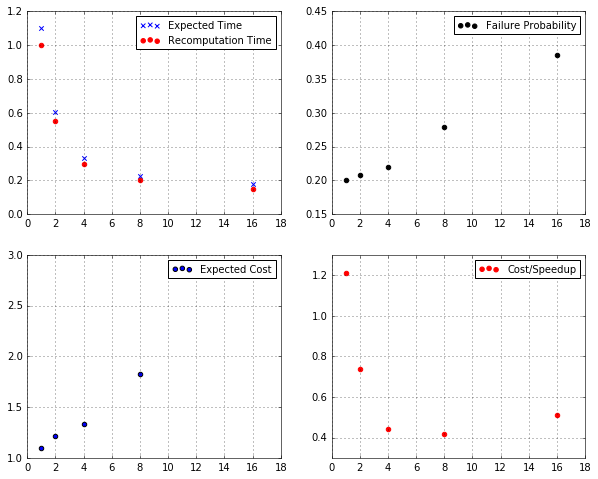

In [197]:
par_speedup_1 = {1:1, 2:0.55, 4:0.3, 8:0.2, 16:0.15}
plot_all(par_speedup_1)

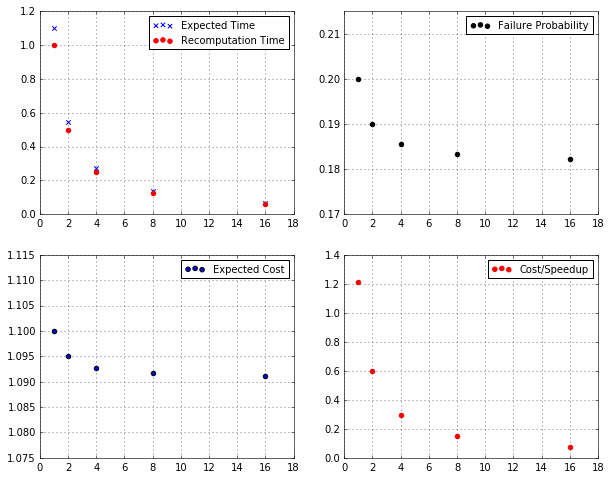

In [198]:
par_speedup_perfect = {1:1, 2:0.5, 4:0.25, 8:1.0/8, 16:1.0/16}
plot_all(par_speedup_perfect)

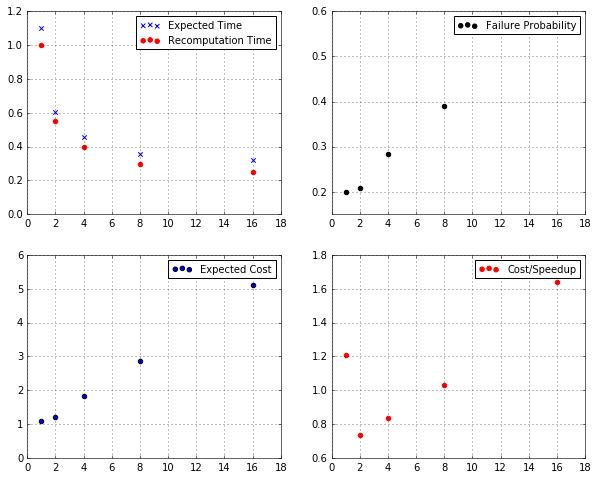

In [199]:
par_speedup_poor = {1:1, 2:0.55, 4:0.4, 8:0.3, 16:0.25}
plot_all(par_speedup_poor)

In [26]:
#confinement data

In [78]:
confinement_runtimes = {16:{16:30, 8:35, 4: 37, 2:39}}
#64:{64,32,16,8,4:21,2}}
#total_num_cpus:{server-cpus:run_time} 


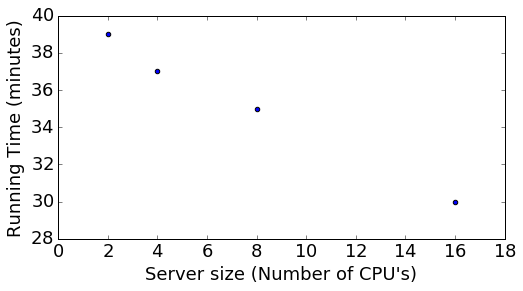

In [68]:
matplotlib.rcParams.update({'font.size': 18})
fig,ax=plt.subplots()
fig.set_size_inches(8,4)
runtimes = confinement_runtimes[16]
server_size = runtimes.keys()
r_minutes = runtimes.values()
ax.scatter(server_size, r_minutes)
ax.set_xlabel("Server size (Number of CPU's)")
ax.set_ylabel("Running Time (minutes)")
plt.savefig("../graphs/Confinement_explore_16.pdf",bbox_inches='tight')

In [69]:
def Exp_time_cost_memoryless(total_cpus, runtimes, prices, mttfs):
    #Assumes memoryless failures etc 
    out = []
    times = runtimes[total_cpus]
    
    for server_size in times.keys():
        T = times[server_size]/60.0 
        num_servers = int(total_cpus/server_size) 
        eT, pfail = ExpectedTime(T, mttfs[server_size], num_servers)
        recomputation = eT-T
        cost = eT*prices[server_size]*num_servers
        ondem_cost = T*prices[server_size]*8*num_servers
        out.append((server_size, eT, T, pfail, cost, ondem_cost))
    
    times = out 
    x=zip(*times)[0]
    ets=zip(*times)[1]
    nofails=zip(*times)[2]
    pfails=zip(*times)[3]
    costs=zip(*times)[4]
    ondem_costs =zip(*times)[5]
    return (x, ets, nofails, pfails, costs, ondem_costs)

In [73]:
(x, ets, nofails, pfails, costs, ondem_costs) = Exp_time_cost_memoryless(16, confinement_runtimes, prices, mttfs)

In [81]:
def plot_run_cost(num_cpus, wkload, runtime_data, prices, mttfs):
    (x, ets, nofails, pfails, costs, ondem_costs) = Exp_time_cost_memoryless(num_cpus, runtime_data, prices, mttfs)
    
    matplotlib.rcParams.update({'font.size': 18})
    fig,ax=plt.subplots()
    fig.set_size_inches(8,4)
    ax.scatter(x, ets, label="Preemptible")
    ax.scatter(x, nofails, label="On-demand", color='r',marker='x')
    ax.set_xlabel("Server Size (Total number of CPUs=16)")
    ax.set_ylabel("Running Time (Hours)")
    ax.legend(fontsize='small')
    fname = "../graphs/{}_{}_time.pdf".format(wkload, num_cpus)
    plt.savefig(fname, bbox_inches="tight")
    
    fig,ax=plt.subplots()
    fig.set_size_inches(8,4)
    ax.scatter(x, costs, label="Preemptible")
    ax.scatter(x, ondem_costs, label="On-demand", color='r',marker='x')
    ax.set_xlabel("Server Size (Total number of CPUs=16)")
    ax.set_ylabel("Expected Cost per Job")
    ax.legend(fontsize='small')
    fname="../graphs/{}_{}_cost.pdf".format(wkload, num_cpus)
    plt.savefig(fname, bbox_inches="tight")


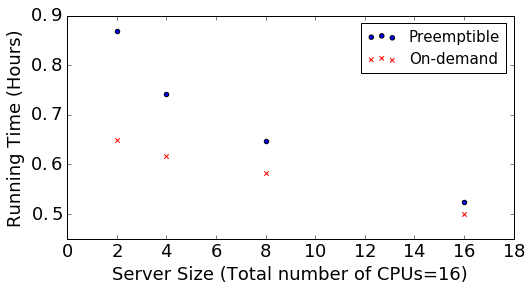

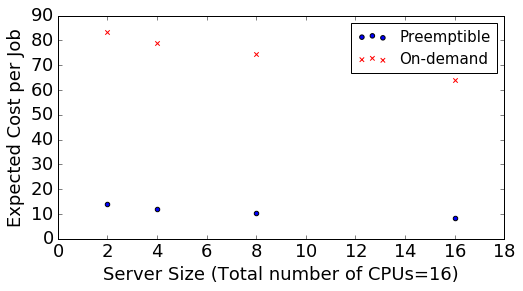

In [82]:
plot_run_cost(16, "confin", confinement_runtimes, prices, mttfs)